IMPORTS

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

DOWNLOAD DATASET

In [0]:
path = untar_data('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet')

path_highres = path/'images'
path_lowres = path/'distorted'

Distort the images.
The following function distorts the image by doing the following :
1. resize the images to 96x96 with Bilinear Interpolation.
2. draw two white rectangles on random positions.
3. Choose a random number between
20 and 60 and set that as the jpeg quality of the image. Lower the number lower the quality of the image.

In [0]:
from PIL import Image, ImageDraw, ImageFont

class distort(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        for n in range(2):
            x = random.randint(0,w//2)
            y = random.randint(0,h//2)
            ImageDraw.Draw(img).rectangle((x,y,x+5,y+5), fill=(255,255,255))
        q = random.randint(10,70)
        img.save(dest, quality=q)

The duration of distortion can be reduced by using the 'fastai' inbuilt function 'parallel' where we pass the the function to be computed with the required parameters.

In [0]:
# Uncomment the below lines the first time you run this program
# il = ImageList.from_folder(path_highres)
# parallel(distort(path_lowres, path_highres), il.items)

In [0]:
bs = 32
size = 128
arch = models.resnet34

In [0]:
src = ImageImageList.from_folder(path_lowres).split_by_rand_pct(0.1, seed =  42)

We do some tranforms on the data. We specify the batch size. Normalise the images using the imagenet_stats because we are going to use a pretrained model.
We use a pretrained model so that we can get rid of the cutouts. To know what was there in place of the cutout, we use a model that knows what possibly was in place of the cutout. Using a model and weights that have been pre-trained on ImageNet is an excellent start when photographs are used as inputs.

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_highres/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)


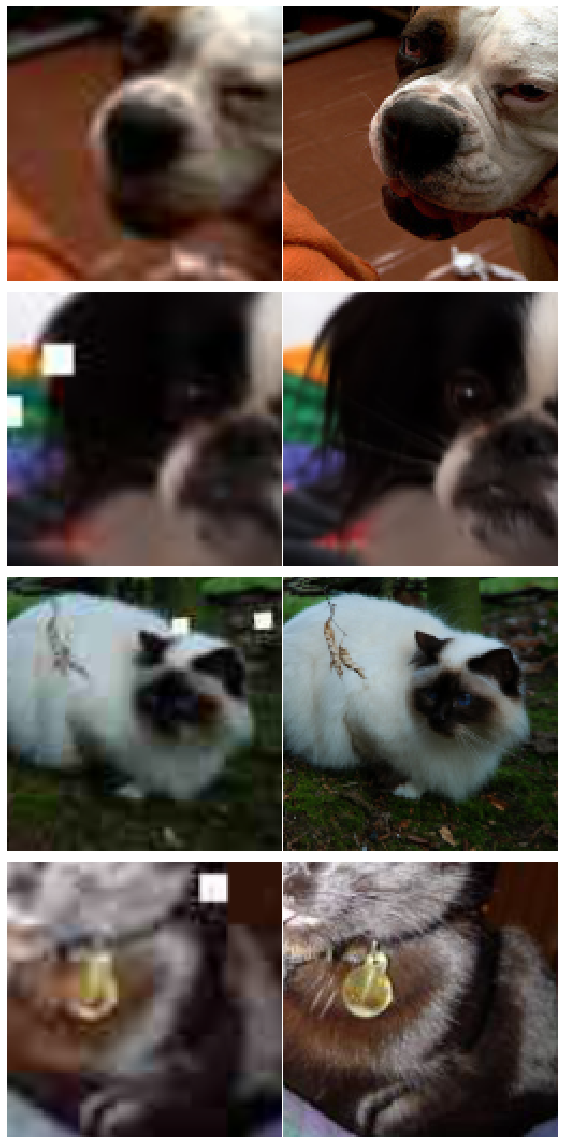

In [99]:
data_gen.show_batch(4)

Hyperparameters
1. Weight Decay (wd) = 1e-3
During training of neural networks, after each update the weights are multiplied by a weight decay value less than 1 to prevent the weights from growing too large. This can be thought of as gradient descent on a quadratic regularization term.

2. y-range = (-3. , 3.) 
When y_range is specified, the last activations go through a sigmoid rescaled to that range.

3. loss_gen = MSELossFlat()
Mean Squared Error between the pixels of the generated and target images. The function flattens the images into vectors to calculate MSE.

In [0]:
wd = 1e-3
y_range = (-3.,3.) 
loss_gen = MSELossFlat() 

We create a kind of generator learner which is a U-Net learner as we generate an output, images in our case.
We will specify an encoder-network (Resnet34 in our case) which is the pretrained part of our model.
We pass the distorted data to the U-Net to get rid




In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd = wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range = y_range, loss_func=loss_gen)

In [102]:
# Initialize learner and fit it.

learn_gen = create_gen_learner()

learn_gen.fit_one_cycle(2, pct_start=0.8)

We have a pretrained part in our model. 
In transfer learning, when we create a learner it will freeze the pretrained part.
We will unfreeze the model and train some more.  

In [103]:
learn_gen.unfreeze()

learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

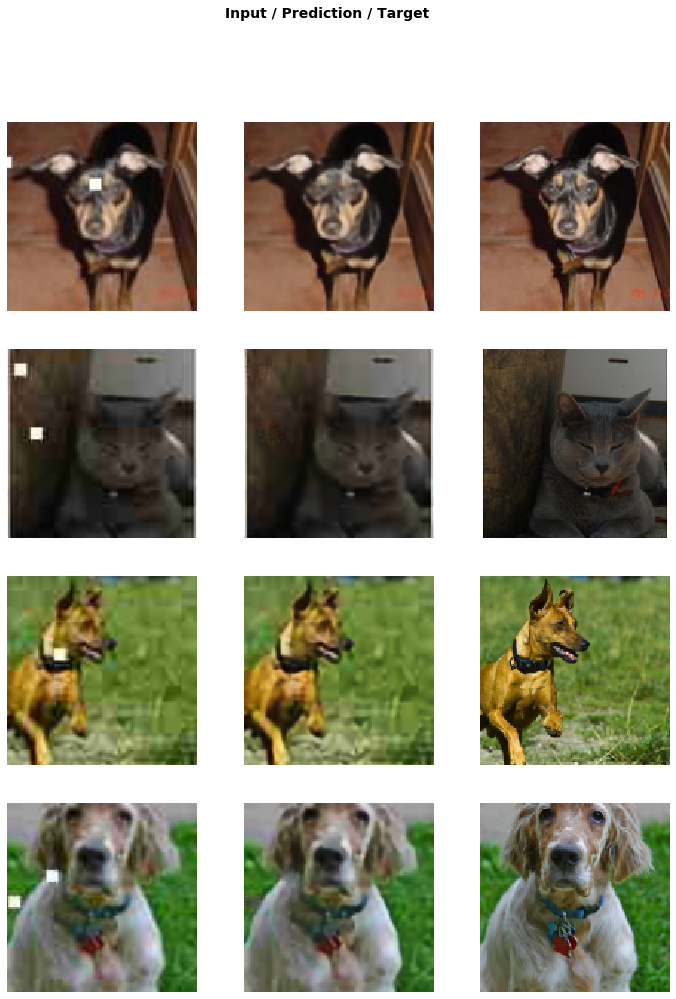

In [104]:
learn_gen.show_results(rows=4)

When we look at results after training, we can notice that, the model does a good job at replacing the cutout portions, which is useful.
But, does not do a great job at upsampling the image.

This is because we want a better loss function than MSE.

Enter GAN, where we will use another model, a binary classification model called the Discriminator, as our Loss Function fine train the generator.

SAVE GENERATED IMAGES

As we need two folders - one with high resolution images and one with low resolution images.

In [0]:
learn_gen.save('gen-pre2') 
learn_gen.load('gen-pre2');


In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    # Go through each batch of data loader and save the predictions in each batch.
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
# Save predictions
save_preds(data_gen.fix_dl)

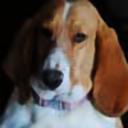

In [110]:
PIL.Image.open(path_gen.ls()[0])

In [111]:
# Reclaim the GPU memory

learn_gen = None
gc.collect()

20

CREATE CRITIC

Train the critic on high resolution images and generated images.

In [0]:
def get_crit_data(classes, bs, size):
  # Split the data randomly for a validation set
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    # Label the images according to the classes
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

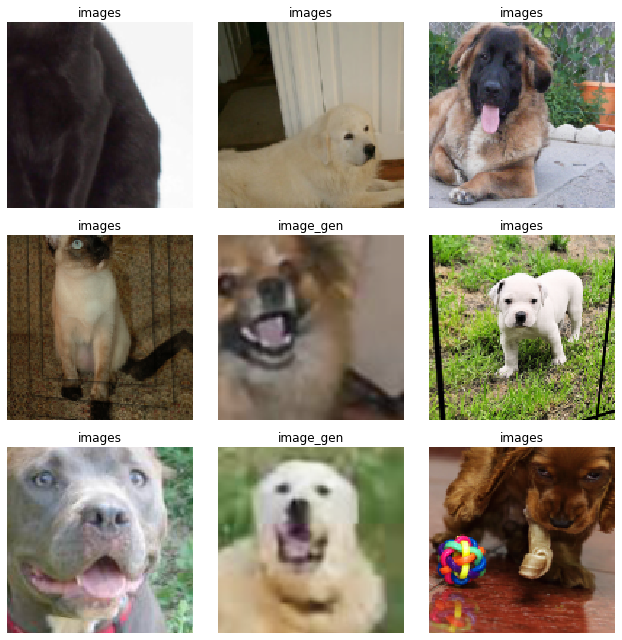

In [113]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

We are using Binary Cross Entropy Classifier.

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [117]:
learn_critic.fit_one_cycle(6, 1e-3)

In [0]:
learn_critic.save('critic-pre2')

We have now pretrained the Generator and the Critic.

In [119]:
learn_crit=None
learn_gen=None
gc.collect()

13767

In [0]:
data_crit = get_crit_data(['distorted', 'images'], bs = bs, size = size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

learn_gen = create_gen_learner().load('gen-pre2')

Now that we have pre-trained the generator and the critic, we now need to train the models turn by turn. To avoid the trouble of finding out how long each model needs to be trained and what learning rate to be used, FastAi has created a GANLearner. We can just pass in the generator and the critic and it will figure out how much time to train the generator and then when to switch to training the discriminator and it will go backward and forward.

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
learn_rate = 1e-4 
epochs = 40

In [125]:
learn.fit(epochs,learn_rate)

In [0]:
learn.save('gan-1c')

In [0]:
learn.data = get_data(16,192)

In [130]:
learn.fit( int(epochs/4), learn_rate/2)

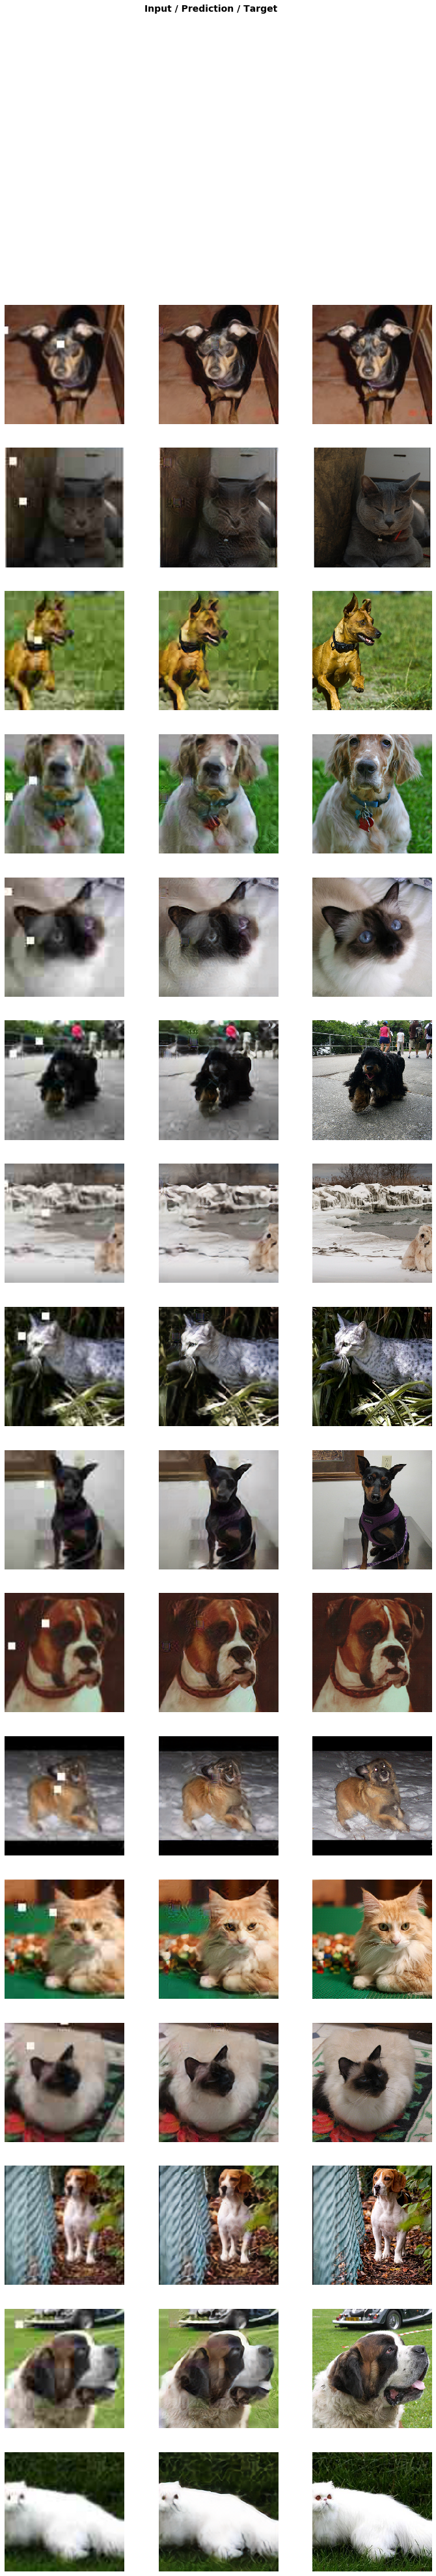

In [131]:
learn.show_results(rows=16)

In [0]:
learn.save('gan-1c')

References - 

https://github.com/hiromis/notes/blob/master/Lesson7.md

https://docs.fast.ai/vision.models.unet.html#DynamicUnet

https://www.youtube.com/watch?v=9spwoDYwW_I


